In [134]:
# Cell 1
# Plotly can be installed by following the steps in:
# https://plot.ly/python/getting-started/
# Biopython can be installed through:
# https://biopython.org/wiki/Download
#
# Numpy, pandas, re, collections, operation are already included with Anaconda
#
#

# For plotting figures
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff

# For arrays and dataframes
import numpy as np
import pandas as pd
import re
import collections
from operator import itemgetter

# For NJ and UPGMA methods as well as displaying the output phylogenetic trees
import Bio as bio
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceMatrix

In [135]:
# Cell 2
# This function was taken from SynMap repository
# It is a basic function to read DagChainer files
# Slight modifications were needed to make it work here
# Reference: https://github.com/LyonsLab/coge/blob/9cb4d5dee8dcd022c0da88dd0da1082b7db825ce/scripts/synmap/dag_tools.py

def dag_array(dagf):
    recs = collections.defaultdict(list)

    fh = open(dagf, 'r')
    qname_len = 0
    sname_len = 0
    qchr_len = 0
    schr_len = 0

    for line in fh:
        if line[0] == '#': continue
        qchr, qname, qstart, qstop, schr, sname, sstart, sstop, score  = line.rstrip("*,\n,+").split("\t")[:9]
        if len(qchr) > qchr_len: qchr_len = len(qchr)
        if len(schr) > schr_len: schr_len = len(schr)
        if len(qname) > qname_len: qname_len = len(qname)
        if len(sname) > sname_len: sname_len = len(sname)
        if not (qname, sname) in recs: recs[qname, sname] = []
        recs[qname, sname].append([qchr, qname, int(qstart), int(qstop), schr, sname, int(sstart), int(sstop), float(score)])

    fh.close()

    arr = []
    for k in sorted(recs, key=itemgetter(1)):
        arr.extend([li for li in sorted(recs[k], key=itemgetter(8))])

    dag_names = ('qchr', 'qname', 'qstart', 'qstop', 'schr', 'sname', 'sstart', 'sstop', 'score')
    dag_types = ['S', 'S', 'i4', 'i4', 'S', 'S', 'i4', 'i4', 'f8']
    dag_types[0] += str(qchr_len)
    dag_types[4] += str(schr_len)
    dag_types[1] += str(qname_len)
    dag_types[5] += str(sname_len)
    
    return np.rec.array(arr, names=dag_names, formats=dag_types)

In [136]:
# Cell 3
# Uncomment any line to test on a different set of genomes
# Comment the line previously left uncommented
# Note that if files are not found, the cell won't proceed any further
# No exception handling is required as we run cell-by-cell in IPython notebooks

# genomes=['ArabidopsisLyrata', 'ArabidopsisThaliana', 'CapsellaRubella', 'LeavenworthiaAlabamica']
genomes=['BrassicaOleracea', 'BrassicaRapa', 'RaphanusRaphanistrum', 'RaphanusSativus']
# genomes=['BrassicaOleracea', 'BrassicaRapa', 'RaphanusSativus']
genomesContracted =[]
inputFiles = []
selfComparisonFiles = []

inputIndices = []
# Fills the file name array based on genome names
for i in range(len(genomes)):
    words=re.findall('[A-Z][a-z]*',genomes[i])
    genomesContracted.append(' '.join([words[0][0]+'.' if j==0 else words[j] for j in range(len(words)) ]))
    for j in range(i+1, len(genomes)):
        inputFiles.append(genomes[j] +'_'+ genomes[i])
        inputIndices.append([j, i])
        selfComparisonFiles.append(genomes[i] +'_'+ genomes[i])

tracePlots = []
# Create a distance matrix (in lower triangular format) for biopython
dm = DistanceMatrix(names=genomesContracted)

# Gets peak similarity, adds peaks similarities to distance matrix
# Adds plots of similarity distribution for the figure in next cell
for i in range(len(inputFiles)):
    df = pd.DataFrame.from_records(dag_array("genome_comparisons/"+inputFiles[i]))
    # Extracts similarities from dag chainer formatted input files
    df = pd.DataFrame(df.apply(lambda row: str(row.qname).split('||')[-1][:-1], axis=1), columns=['similarity'])
    df['similarity'] = df['similarity'].astype(float)
    df['similarity'] = df['similarity'].astype(int)
    # Groups dataframe by similarity
    # By doing this, we get a dataframe which shows us the number of pairs with corresponding similarities
    df = df.groupby(['similarity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
    
    # Adds similarity to distance matrix
    j = inputIndices[i][0]
    k = inputIndices[i][1]
    dm[j, k] = 1-int(df['similarity'].iloc[0])/100
    
    # Sorts values by similarity to plot a curve
    df = df.sort_values(by=['similarity'])
    trace = go.Scatter(
                    x=df['similarity'], y=df['counts'],
                    mode='lines', name=genomesContracted[inputIndices[i][0]] + " vs " + genomesContracted[inputIndices[i][1]]
                   )
    # Append trace plot
    tracePlots.append(trace)

# Performs the same function as previous for-loop
# For self-comparison of genomes
# It does not add similarity to distance matrix
for i in range(len(selfComparisonFiles)):
    df = pd.DataFrame.from_records(dag_array("genome_comparisons/"+selfComparisonFiles[i]))
    df = pd.DataFrame(df.apply(lambda row: str(row.qname).split('||')[-1][:-1], axis=1), columns=['similarity'])
    df['similarity'] = df['similarity'].astype(float)
    df['similarity'] = df['similarity'].astype(int)
    df = df.groupby(['similarity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
    
    # Sort values by similarity to plot a curve
    df = df.sort_values(by=['similarity'])
    trace = go.Scatter(
                    x=df['similarity'], y=df['counts'],
                    mode='lines', name=genomesContracted[inputIndices[i][0]] + " vs. " + genomesContracted[inputIndices[i][0]]
                   )
    tracePlots.append(trace)
    
    
# Prints the distance matrix (note that it contains inverse of similarities i.e: 1-peak_similarity/100)
print (dm)

B. Oleracea	0
B. Rapa	0.040000000000000036	0
R. Raphanistrum	0.06999999999999995	0.06000000000000005	0
R. Sativus	0.06999999999999995	0.06999999999999995	0.030000000000000027	0
	B. Oleracea	B. Rapa	R. Raphanistrum	R. Sativus


In [137]:
# Cell 4
# Sets layout for similarity distribution
layout = go.Layout(title='Similarity Distributions',
                   plot_bgcolor='rgb(255, 255,255)',
                   xaxis=dict(title='Similarity (%)'),
                   yaxis=dict(title='Frequency (per %)'))

# Uses the trace plots added in previous cell
fig = go.Figure(data=tracePlots, layout=layout)

# Plot data in the notebook
iplot(fig)

Tree constructed by UPGMA


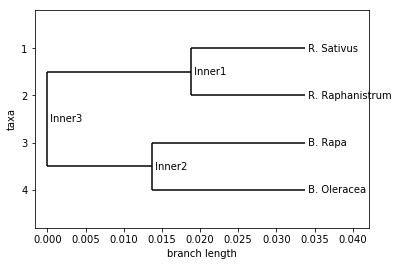

Tree constructed by NJ


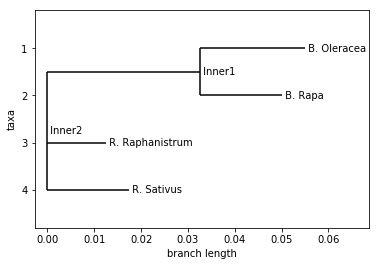

In [138]:
# Cell 5
# From Bio package
# Note: If it says no bio or Phylo package, run all cells again or restart notebook
# (seems to be a bug with ipython or biopython package)
constructor = DistanceTreeConstructor()

# Constructs tree using UPGMA
print("Tree constructed by UPGMA")
tree = constructor.upgma(dm)
bio.Phylo.draw(tree)

# Constructs tree using NJ
print("Tree constructed by NJ")
tree = constructor.nj(dm)
bio.Phylo.draw(tree)